# 고양이 얼굴 탐지 (검출)
---

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## 데이터 준비

In [149]:
# !gdown https://drive.google.com/uc?id=1jNlnTFMzxaxZ799JcvVnN_aHsx1O3OeL

In [150]:
# !unzip cats_sample.zip

In [151]:
# !gdown https://drive.google.com/uc?id=1-RBvPOYycsSpS7rVP0Pqwcbh18lZYDeb

In [152]:
# !unzip BBRegression.zip

In [153]:
# xml 함수 가져오기
# file path를 지정하면 해당 폴더의 xml을 하나씩 파싱하여 dataframe 형태로 저장

import glob
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [154]:
IMAGE_PATH = '/content/BBRegression'

In [155]:
import os

FILE_NAME = 'label_cats.csv'

csv_path = os.path.join(IMAGE_PATH, 'train')
xml_df = xml_to_csv(csv_path)
xml_df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cat-2_jpg.rf.6b1b1624fe8ccd6c05c7d9b1935bb304.jpg,224,224,cat,36,9,159,123
1,cat-210_jpg.rf.d0f3c57f2d93b75a913b8ca95fe351b...,224,224,cat,20,8,206,190
2,cat-212_jpg.rf.6410693af68b7e92e7d9b6cece7538b...,224,224,cat,18,3,187,210
3,cat-227_jpg.rf.b0e39e49b4f074a8b151a2d130a1390...,224,224,cat,34,11,142,120
4,cat-111_jpg.rf.3a2689de6862347f22c8e43b13b0710...,224,224,cat,35,37,173,152


In [156]:
xml_df.to_csv(FILE_NAME)

In [157]:
xml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  91 non-null     object
 1   width     91 non-null     int64 
 2   height    91 non-null     int64 
 3   class     91 non-null     object
 4   xmin      91 non-null     int64 
 5   ymin      91 non-null     int64 
 6   xmax      91 non-null     int64 
 7   ymax      91 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 5.8+ KB


In [158]:
images = xml_df.iloc[:,0].values
images[:5]

array(['cat-2_jpg.rf.6b1b1624fe8ccd6c05c7d9b1935bb304.jpg',
       'cat-210_jpg.rf.d0f3c57f2d93b75a913b8ca95fe351b9.jpg',
       'cat-212_jpg.rf.6410693af68b7e92e7d9b6cece7538b2.jpg',
       'cat-227_jpg.rf.b0e39e49b4f074a8b151a2d130a13903.jpg',
       'cat-111_jpg.rf.3a2689de6862347f22c8e43b13b07102.jpg'],
      dtype=object)

In [159]:
points = xml_df.iloc[:, 4:].values
points[:4]

array([[ 36,   9, 159, 123],
       [ 20,   8, 206, 190],
       [ 18,   3, 187, 210],
       [ 34,  11, 142, 120]])

## 시각화

In [160]:
import PIL
# 이미지 읽기

dataset_images = []
dataset_bbs = [] # 정보 저장 bounding box

for file, point in zip(images, points):
  f = os.path.join(IMAGE_PATH, 'train', file)
  image = PIL.Image.open(f)
  arr = np.array(image)

  dataset_images.append(arr)
  dataset_bbs.append(point)

dataset_images = np.array(dataset_images)
dataset_bbs = np.array(dataset_bbs)

In [161]:
dataset_images.shape, dataset_bbs.shape

((91, 224, 224, 3), (91, 4))

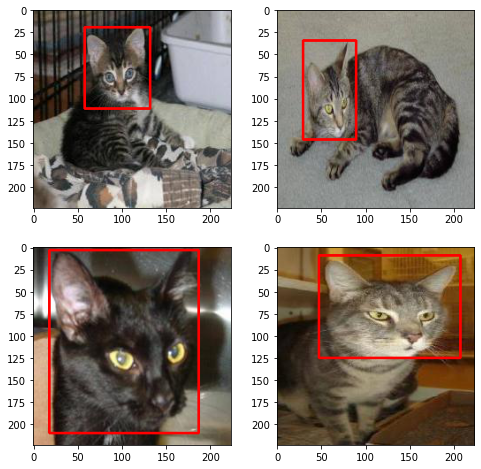

In [162]:
import cv2

samples = np.random.randint(dataset_images.shape[0], size=4)

plt.figure(figsize=(8,8))
for i, idx in enumerate(samples):
  points = dataset_bbs[idx].reshape(2,2)

  img = cv2.rectangle(dataset_images[idx].copy(),
                      tuple(points[0]),
                      tuple(points[1]),
                      color=(255,0,0),
                      thickness=2
                      )
  plt.subplot(2,2,i+1)
  plt.imshow(img)

plt.show()

In [163]:
np.savez('cat_bbs.npz',
         image=dataset_images,
         bbs=dataset_bbs)

## 라벨링 데이터 다운로드, 전처리

In [164]:
dataset = np.load('cat_bbs.npz')

X = dataset['image']
y = dataset['bbs']

X.shape, y.shape

((91, 224, 224, 3), (91, 4))

In [165]:
# 검증데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2)
X_train.shape, X_val.shape

((72, 224, 224, 3), (19, 224, 224, 3))

In [166]:
# 정규화
X_train = X_train.astype('float32')/255.
X_val = X_val.astype('float32')/255.

In [167]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

y_train.dtype

dtype('float32')

## 모델

In [168]:
from tensorflow.keras.applications import MobileNetV2

base = MobileNetV2(input_shape = (224, 224, 3),
                  include_top = False,
                  weights = 'imagenet')
base.trainable = False

model = keras.Sequential([
    base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4)
    # 점 4개를 찾을것 (좌표)
])

model.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = ['mse']
)

In [169]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_5 (Flatten)         (None, 62720)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               8028288   
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 4)                 260       
                                                                 
Total params: 10,294,788
Trainable params: 8,036,804
Non-trainable params: 2,257,984
___________________________________

In [170]:
# callback
ckpt_path = '/content/ckpt/cats_bbs.ckpt'

ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [171]:
EPOCHS = 30
BATCH_SIZE = 16

log = model.fit(X_train, y_train,
          epochs = EPOCHS,
          batch_size = BATCH_SIZE,
          validation_data = (X_val, y_val),
          callbacks = [ckpt_cb],
          verbose = 1)

Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 5752.3975 - mse: 5752.3975
Epoch 1: val_loss improved from inf to 3158.21021, saving model to /content/ckpt/cats_bbs.ckpt
5/5 [==============================] - 4s 338ms/step - loss: 5752.3975 - mse: 5752.3975 - val_loss: 3158.2102 - val_mse: 3158.2102
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 1199.8444 - mse: 1199.8444
Epoch 2: val_loss improved from 3158.21021 to 1357.94348, saving model to /content/ckpt/cats_bbs.ckpt
5/5 [==============================] - 1s 143ms/step - loss: 1199.8444 - mse: 1199.8444 - val_loss: 1357.9435 - val_mse: 1357.9435
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 915.2309 - mse: 915.2309  
Epoch 3: val_loss improved from 1357.94348 to 1091.42188, saving model to /content/ckpt/cats_bbs.ckpt
5/5 [==============================] - 1s 139ms/step - loss: 915.2309 - mse: 915.2309 - val_loss: 1091.4219 - val_mse: 1091.4219
Epoch 4/30
5/5 [===============

In [172]:
model.load_weights(ckpt_path)

## 평가

In [173]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.plot(hist['epoch'], hist['mse'], label="Train MSE")
  plt.plot(hist['epoch'], hist['val_mse'], label="Val MSE")
  plt.legend()
  plt.show()

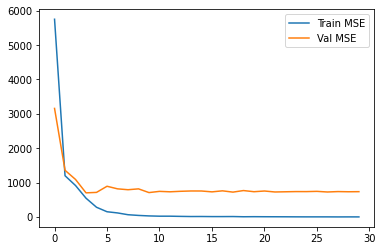

In [174]:
plot_history(log)

### 모델 저장

In [175]:
# 1. keras 형태
model.save('cats_bbs_regression.h5')

# 모델에 있는 레이어의 구조와 weight를 모두 한번에 저장

my_model = tf.keras.models.load_model('cats_bbs_regression.h5')
my_model.summary(0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_5 (Flatten)         (None, 62720)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               8028288   
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 4)                 260       
                                                                 
Total params: 10,294,788
Trainable params: 8,036,804
Non-trainable params: 2,257,984
___________________________________

In [176]:
# 2. tensorflow 형태

model.save('my_cats_model')
# 폴더 이름을 지정
# -> pb 형태로 저장

your_model = tf.keras.models.load_model('my_cats_model')
your_model.summary(0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_5 (Flatten)         (None, 62720)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               8028288   
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 4)                 260       
                                                                 
Total params: 10,294,788
Trainable params: 8,036,804
Non-trainable params: 2,257,984
___________________________________

### 테스트 이미지 파일 읽기

In [177]:
import os

FILE_NAME = 'label_cats.csv'

test_csv_path = os.path.join(IMAGE_PATH, 'test')
test_df = xml_to_csv(test_csv_path)
test_df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cat-273_jpg.rf.af452afbb9bb8767d534653a290090c...,224,224,cat,9,6,130,194
1,cat-268_jpg.rf.942ee4c485010ed238a09f80680dc0b...,224,224,cat,55,2,189,87
2,cat-144_jpg.rf.50b4b01d0df37d977b1341837708aa1...,224,224,cat,149,63,220,153
3,cat-249_jpg.rf.eba7bf7e8fe79642e84fdc3abc72e6f...,224,224,cat,38,26,174,146
4,cat-188_jpg.rf.4bb417309154766edeac39c9c9d083f...,224,224,cat,38,3,207,87


In [178]:
t_images = test_df.iloc[:,0].values
t_points = test_df.iloc[:, 4:].values

In [179]:
test_dataset_images = []
test_dataset_bbs = [] # 정보 저장 bounding box

for file, point in zip(t_images, t_points):
  f = os.path.join(IMAGE_PATH, 'test', file)
  image = PIL.Image.open(f)
  arr = np.array(image)

  test_dataset_images.append(arr)
  test_dataset_bbs.append(point)

test_dataset_images = np.array(test_dataset_images)
test_dataset_bbs = np.array(test_dataset_bbs)

In [180]:
X_test = test_dataset_images
y_test = test_dataset_bbs

X_test.shape, y_test.shape

((11, 224, 224, 3), (11, 4))

In [181]:
y_pred = model.predict(X_test).astype(int)
y_pred[:3]

1/1 [==============================] - 1s 706ms/step


array([[ 23,  -1, 103,  92],
       [ 21,   0, 102,  75],
       [ 30,   0, 116,  92]])

In [182]:
y_test[:3]

array([[  9,   6, 130, 194],
       [ 55,   2, 189,  87],
       [149,  63, 220, 153]])

In [183]:
# 이미지만 로딩 X_test
# y_pred = model.predict(X_test)
# y_pred 를 정수형 astype
# 이미지, y_pred 시각화

### 테스트 이미지

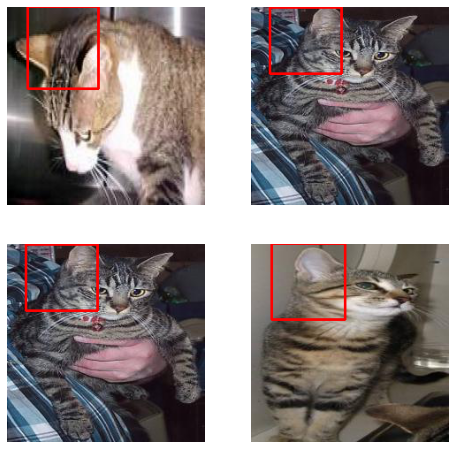

In [184]:
samples = np.random.randint(11, size=4)

plt.figure(figsize=(8,8))
for i, idx in enumerate(samples):
  points = y_pred[idx].reshape(2,2)

  img = cv2.rectangle(test_dataset_images[idx].copy(),
                      tuple(points[0]),
                      tuple(points[1]),
                      color=(255,0,0),
                      thickness=2
                      )
  plt.subplot(2,2,i+1)
  plt.imshow(img)
  plt.axis('off')

plt.show()

In [185]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 791ms/step - loss: 3182.5940 - mse: 3182.5940


[3182.593994140625, 3182.593994140625]